In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from glob import glob
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
print(os.listdir("../input/skin-cancer-mnist-ham10000"))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [10]:
#Matching the row info in HAM10000_metadata with corresponding images
img_dir = '../input/skin-cancer-mnist-ham10000'
image_path = glob(os.path.join(img_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_path}

In [11]:
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [12]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [13]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [14]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
### Returns categorical values and turns them into integer codes
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [15]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [16]:
df.shape

(10015, 10)

In [17]:
label={
    ' Actinic keratoses':0,
    'Basal cell carcinoma':1,
    'Benign keratosis-like lesions':2,
    'Dermatofibroma':3,
    'Melanocytic nevi':4,
    'Vascular lesions':5,
    'Melanoma':6,
}

## Data Cleaning

In [18]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [19]:
## We replace the null values with mean age
df['age'].fillna((df['age'].mean()), inplace = True)

### Visualizing the images

In [20]:
img_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')

In [21]:
img_data.sample(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
4673,234,148,156,236,148,160,237,152,165,236,...,218,147,139,216,147,140,213,144,139,4
1153,153,105,102,169,127,128,179,141,145,182,...,185,144,157,181,140,149,174,135,150,3
6903,157,117,128,162,124,135,166,128,143,172,...,148,107,98,141,98,89,126,86,79,4
4541,216,124,146,218,123,151,223,132,156,225,...,207,137,139,204,135,138,200,133,139,4
2727,195,155,137,200,160,142,203,165,147,206,...,200,160,137,200,158,138,197,158,136,1
6901,26,18,15,63,52,46,136,118,110,160,...,30,21,14,28,17,11,21,7,5,4
5198,228,134,147,231,135,147,233,138,150,233,...,215,136,131,217,139,133,216,138,132,4
8677,181,133,128,188,138,134,195,142,138,201,...,200,155,141,194,148,132,189,143,125,4
9610,176,153,174,177,154,174,180,157,177,182,...,175,150,170,177,153,173,175,151,172,4
2140,139,95,82,145,102,89,153,109,98,162,...,153,105,99,169,130,129,161,122,122,6


In [22]:
img_rescale = img_data/255

In [23]:
img_rescale.shape

(10015, 2353)

In [24]:
img_rescale.isnull().sum()

pixel0000    0
pixel0001    0
pixel0002    0
pixel0003    0
pixel0004    0
            ..
pixel2348    0
pixel2349    0
pixel2350    0
pixel2351    0
label        0
Length: 2353, dtype: int64

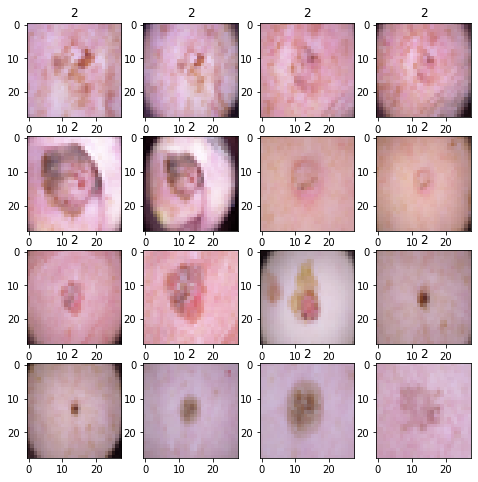

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(img_rescale.iloc[i, :2352].values.reshape(28,28,3))
    plt.title(img_data.iloc[i,2352])
    

### Splitting the dataset

In [26]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


### Resizing the image




In [28]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

In [50]:


df['image'].map(lambda x: x.shape).value_counts()



(100, 100, 3)    10015
Name: image, dtype: int64

In [51]:
from tensorflow.keras.utils import to_categorical

features = df.drop(columns = ['cell_type_idx'], axis = 1)
label = df['cell_type_idx']

In [85]:
from sklearn.model_selection import train_test_split
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(features, label, test_size = 0.2)

### Normalization

In [86]:
x_train = np.asarray(X_train_data['image'].tolist())
x_test = np.asarray(X_test_data['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

X_train = (x_train - x_train_mean)/x_train_std
X_test = (x_test - x_test_mean)/x_test_std

In [68]:
X_train

array([[[[ 0.19816569, -1.05361832, -0.57880369],
         [ 0.24133066, -1.05361832, -0.57880369],
         [ 0.52190294, -0.81621101, -0.27664893],
         ...,
         [ 0.52190294, -0.75146356, -0.47089128],
         [ 0.52190294, -0.70829859, -0.40614383],
         [ 0.45715549, -0.79462853, -0.49247376]],

        [[ 0.45715549, -0.90254094, -0.36297886],
         [ 0.60823287, -0.85937597, -0.36297886],
         [ 0.71614529, -0.77304604, -0.27664893],
         ...,
         [ 0.65139784, -0.70829859, -0.49247376],
         [ 0.62981535, -0.64355114, -0.36297886],
         [ 0.62981535, -0.64355114, -0.38456135]],

        [[ 0.54348542, -0.83779349, -0.27664893],
         [ 0.6945628 , -0.81621101, -0.27664893],
         [ 0.71614529, -0.88095846, -0.36297886],
         ...,
         [ 0.62981535, -0.66513363, -0.40614383],
         [ 0.65139784, -0.64355114, -0.36297886],
         [ 0.62981535, -0.66513363, -0.40614383]],

        ...,

        [[ 0.75931025, -0.47089128, -0

#### One hot encoding the labels

In [87]:

y_train = to_categorical(y_train_data, num_classes = 7)
y_test = to_categorical(y_test_data, num_classes = 7)


In [70]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization

In [88]:
model = Sequential()
        
# [+] 1st convolutional layer
model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 2nd convolutional layer
model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 3rd convolutional layer
model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="same"))
model.add(BatchNormalization())

# [+] 4th convolutional layer
model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())

# [+] 5th convolutional layer
model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten())  # [+] Convert the Conv2D objects into one List.

# [+] 6th, Dense layer:
# From the Docs: 
# A Dense layer feeds all outputs from the previous layer to all its neurons,
# each neuron providing one output to the next layer.
# source: www.stackoverflow.com
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# [+] 7th Dense layer
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# [+] 8th output layer
model.add(Dense(7, activation = 'softmax'))

In [72]:
# model = Sequential()
# input_shape = (100, 100, 3)
# num_classes = 7
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
# model.add(MaxPool2D(pool_size = (2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.40))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()

In [89]:
from tensorflow.keras.optimizers import Adam
EarlyStop = keras.callbacks.EarlyStopping(
               min_delta = 0.001,
               patience = 10 ,
               verbose = 0
)

optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None)

model.compile(
    optimizer =optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

### Splitting the training into validation set

In [90]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [91]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            learning_rate=0.00001)

In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

epochs = 30
batch_size = 32
#datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2)
#datagen.fit(X_train)

history = model.fit(X_train,y_train, epochs = epochs,
                    batch_size=batch_size,
                    callbacks = [EarlyStop, learning_rate_reduction],
                    validation_data = (X_valid, y_valid))

Epoch 1/50
226/226 [==============================] - 73s 323ms/step - loss: 0.8461 - accuracy: 0.7516 - val_loss: 0.7188 - val_accuracy: 0.7594
Epoch 2/50
226/226 [==============================] - 70s 311ms/step - loss: 0.6477 - accuracy: 0.7709 - val_loss: 0.6761 - val_accuracy: 0.7731
Epoch 3/50
226/226 [==============================] - 70s 310ms/step - loss: 0.6262 - accuracy: 0.7817 - val_loss: 0.6956 - val_accuracy: 0.7656
Epoch 4/50
226/226 [==============================] - 70s 309ms/step - loss: 0.5715 - accuracy: 0.7932 - val_loss: 0.7191 - val_accuracy: 0.7618
Epoch 5/50
226/226 [==============================] - 71s 316ms/step - loss: 0.5659 - accuracy: 0.7946 - val_loss: 0.9165 - val_accuracy: 0.7756
Epoch 6/50
226/226 [==============================] - 70s 308ms/step - loss: 0.5415 - accuracy: 0.8062 - val_loss: 0.7891 - val_accuracy: 0.7581
Epoch 7/50
226/226 [==============================] - 70s 309ms/step - loss: 0.5158 - accuracy: 0.8128 - val_loss: 0.7647 - val_ac

### 

In [94]:
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

63/63 [==============================] - 6s 90ms/step - loss: 0.8027 - accuracy: 0.7559
Accuracy: 75.59%


### 

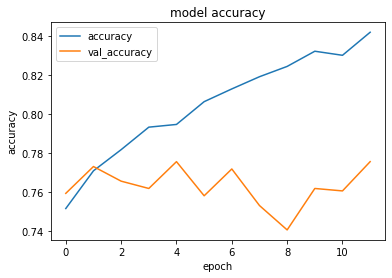

In [98]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()
display_accuracy()

